# Project: Movie Reviews Classification (Machine Learning for Texts)

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labeling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

try:
    plt.style.use('seaborn-v0_8')
except:
    plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
try:
    df_reviews = pd.read_csv('datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
except:
    df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.head(10)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281
5,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,This is the first movie I've seen from Singapo...,9,pos,1,test,9282
6,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Yes non-Singaporean's can't see what's the big...,9,pos,1,test,9283
7,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,This true story of Carlson's Raiders is more o...,2,neg,0,train,9903
8,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,Should have been titled 'Balderdash!' Little i...,2,neg,0,train,9905
9,tt0035958,movie,'Gung Ho!': The Story of Carlson's Makin Islan...,'Gung Ho!': The Story of Carlson's Makin Islan...,1943,\N,88,0,"Drama,History,War",6.1,1240,The movie 'Gung Ho!': The Story of Carlson's M...,4,neg,0,train,9904


In [6]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [7]:
df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


In [8]:
df_reviews.isnull().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [9]:
df_reviews = df_reviews.dropna(subset=['average_rating', 'votes'])

In [10]:
df_reviews.duplicated().sum()

0

In [11]:
df_reviews['review'].duplicated().sum()

91

In [12]:
df_reviews[df_reviews['review'].duplicated()]

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
1370,tt0081949,tvMiniSeries,A Town Like Alice,A Town Like Alice,1981,1981,301,0,"Drama,Romance,War",8.3,849,I have seen this film at least 100 times and I...,10,pos,1,test,9768
1630,tt0098994,movie,"After Dark, My Sweet","After Dark, My Sweet",1990,\N,114,0,"Crime,Drama,Mystery",6.6,3098,THE JIST: See something else. This film was hi...,7,pos,1,train,7729
1983,tt0115509,movie,All Dogs Go to Heaven 2,All Dogs Go to Heaven 2,1996,\N,82,0,"Adventure,Animation,Family",5.5,5396,This movie is very scary with scenes where the...,1,neg,0,test,7914
2132,tt0092545,movie,Amazing Grace and Chuck,Amazing Grace and Chuck,1987,\N,114,0,"Drama,Sport",6.0,1235,I saw this in the summer of 1990. I'm still an...,1,neg,0,train,6320
2236,tt0181288,movie,American Movie,American Movie,1999,\N,107,0,"Comedy,Documentary",7.9,16416,This is an Emperor's New Clothes situation. So...,1,neg,0,test,1470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46064,tt0038245,movie,Where Do We Go from Here?,Where Do We Go from Here?,1945,\N,74,0,"Fantasy,Musical",5.8,220,"During a Kurt Weill celebration in Brooklyn, W...",8,pos,1,train,4267
47052,tt0365960,movie,Zero Day,Zero Day,2002,\N,92,0,Drama,7.2,3947,Everyone knows about this ''Zero Day'' event. ...,10,pos,1,train,11470
47194,tt0463392,movie,Zombie Nation,Zombie Nation,2004,\N,81,0,Horror,2.0,7850,German filmmaker Ulli Lommel has managed a tas...,1,neg,0,train,10108
47290,tt0972534,tvSeries,iCarly,iCarly,2007,2012,30,0,"Comedy,Family,Romance",6.6,31143,Nickelodeon has gone down the toilet. They hav...,1,neg,0,test,5655


In [13]:
df_reviews = df_reviews.drop_duplicates(subset='review').reset_index(drop=True)

The data was loaded and checked. Everything checked out except for duplicate reviews which have since been dropped from the dataset.

## EDA

Let's check the number of movies and reviews over years.

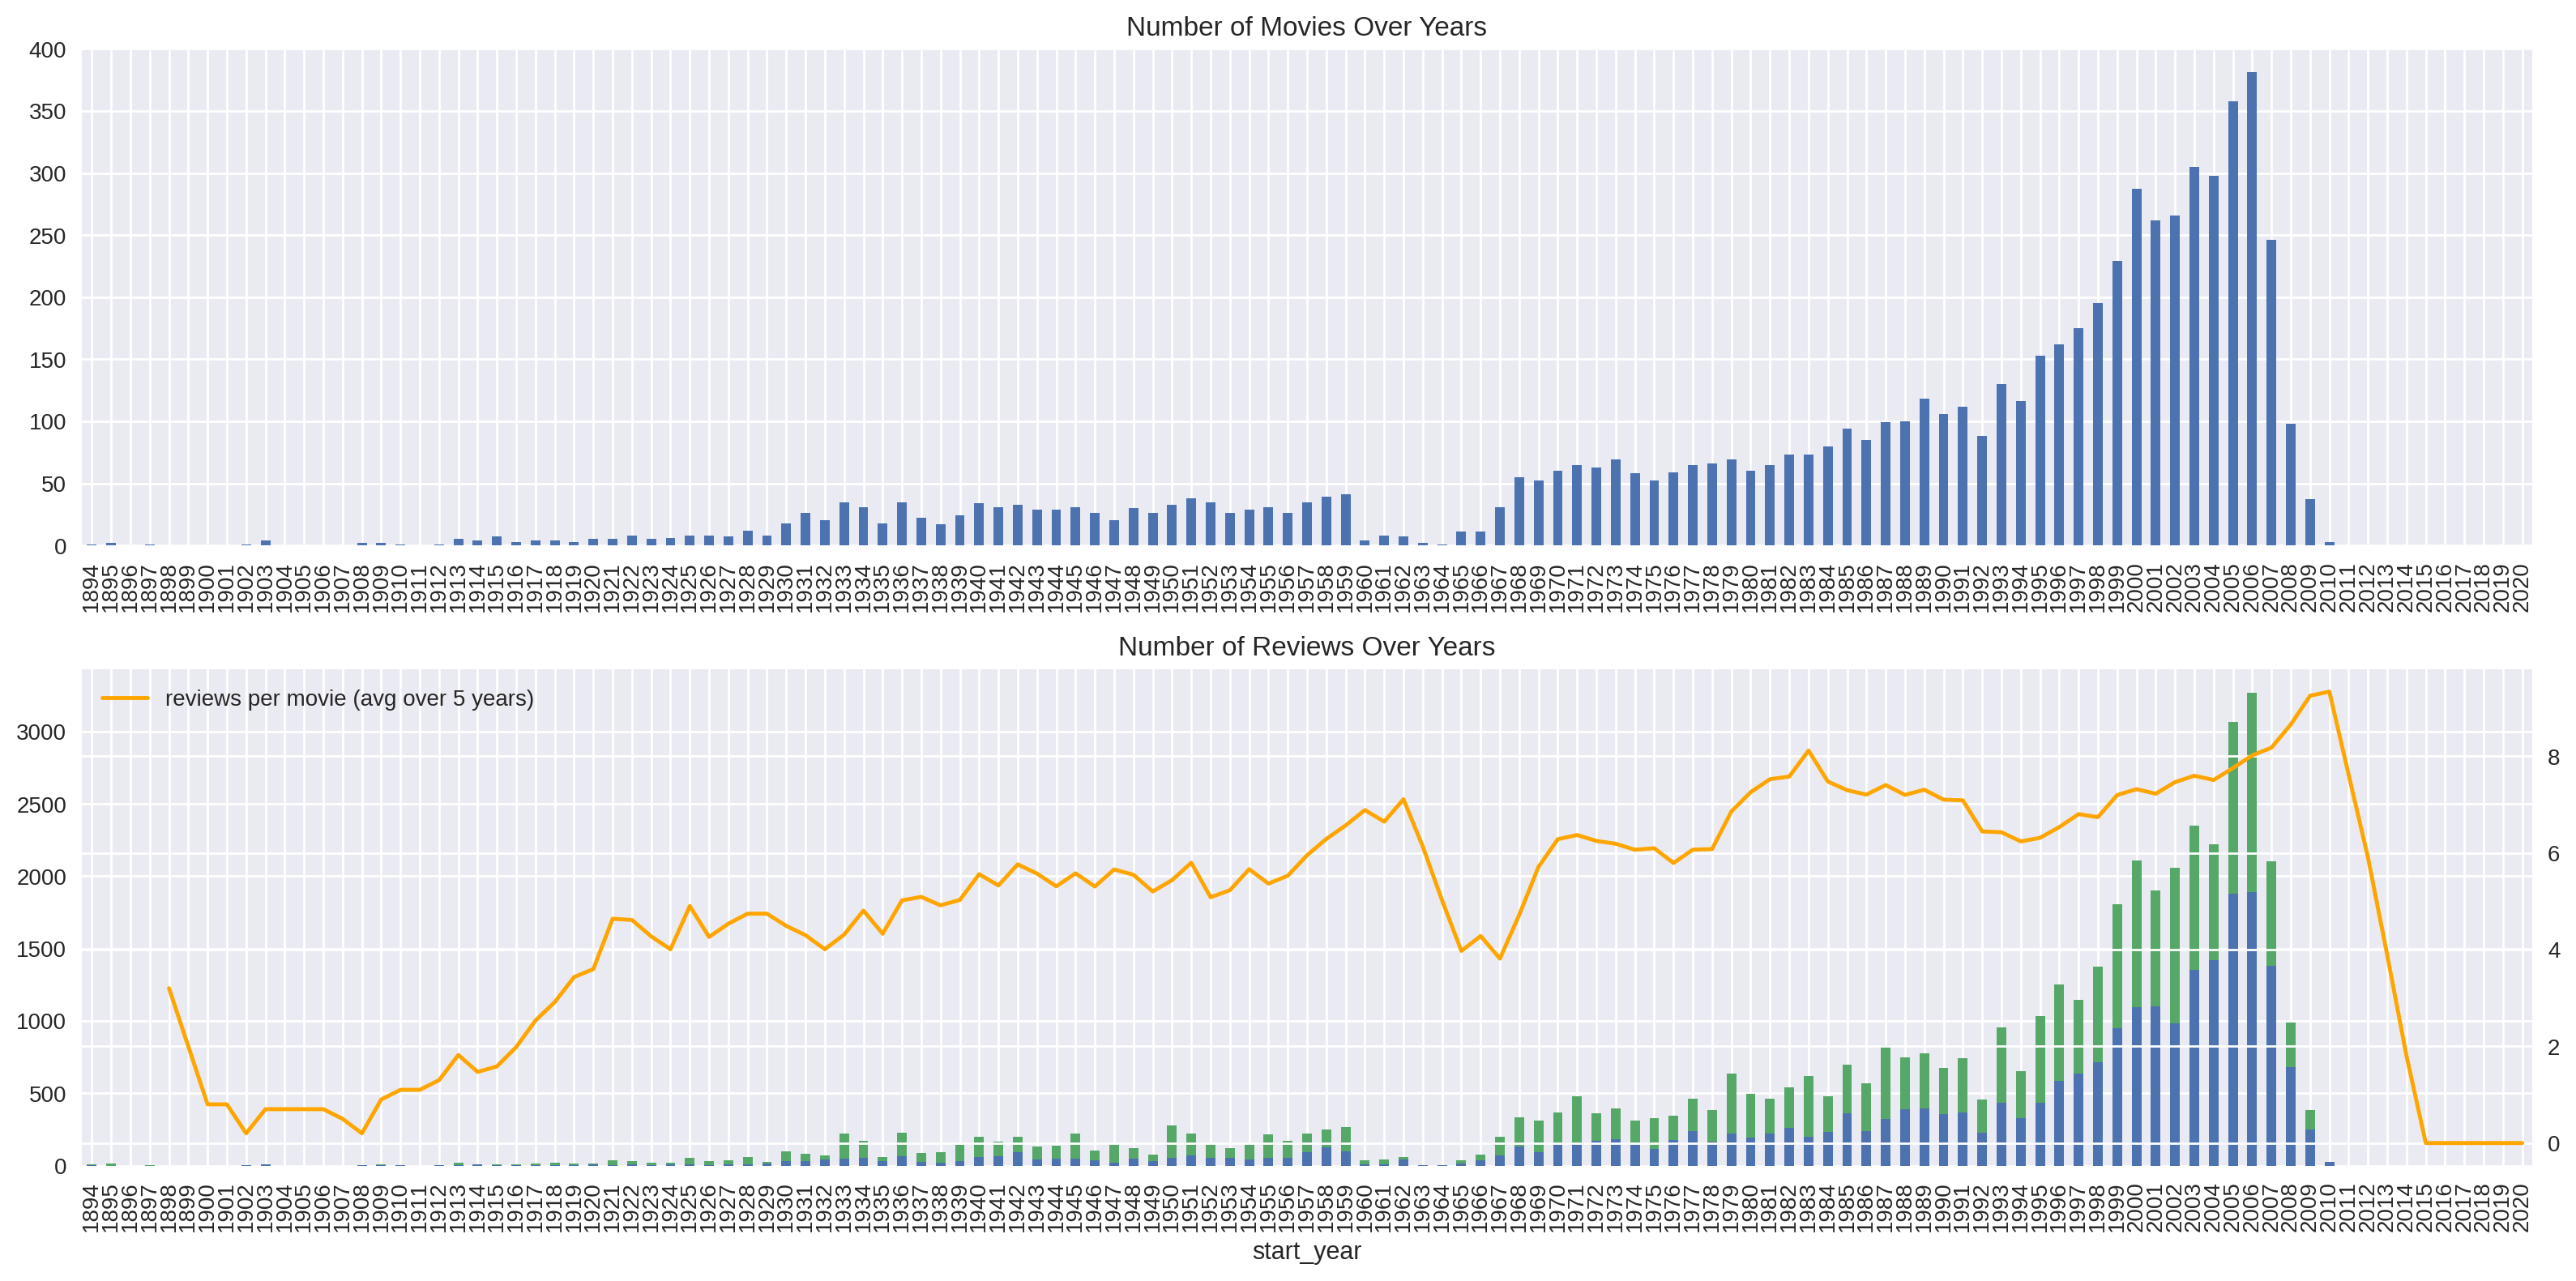

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Two subplots are visualized. The first subplot displays a bar chart showing the number of movies over the years. The second subplot combines a stacked bar chart of positive and negative reviews over the years, in addition to a line graph showing the average number of reviews per movie (smoothed over 5 years).

The abundance and availablity of movie reviews is likely aligned with the rise in popularity and usage of the internet starting from the 1990s to present day. Prior to this time, (digital) record keeping of such data might not have beeen as prevalent.

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

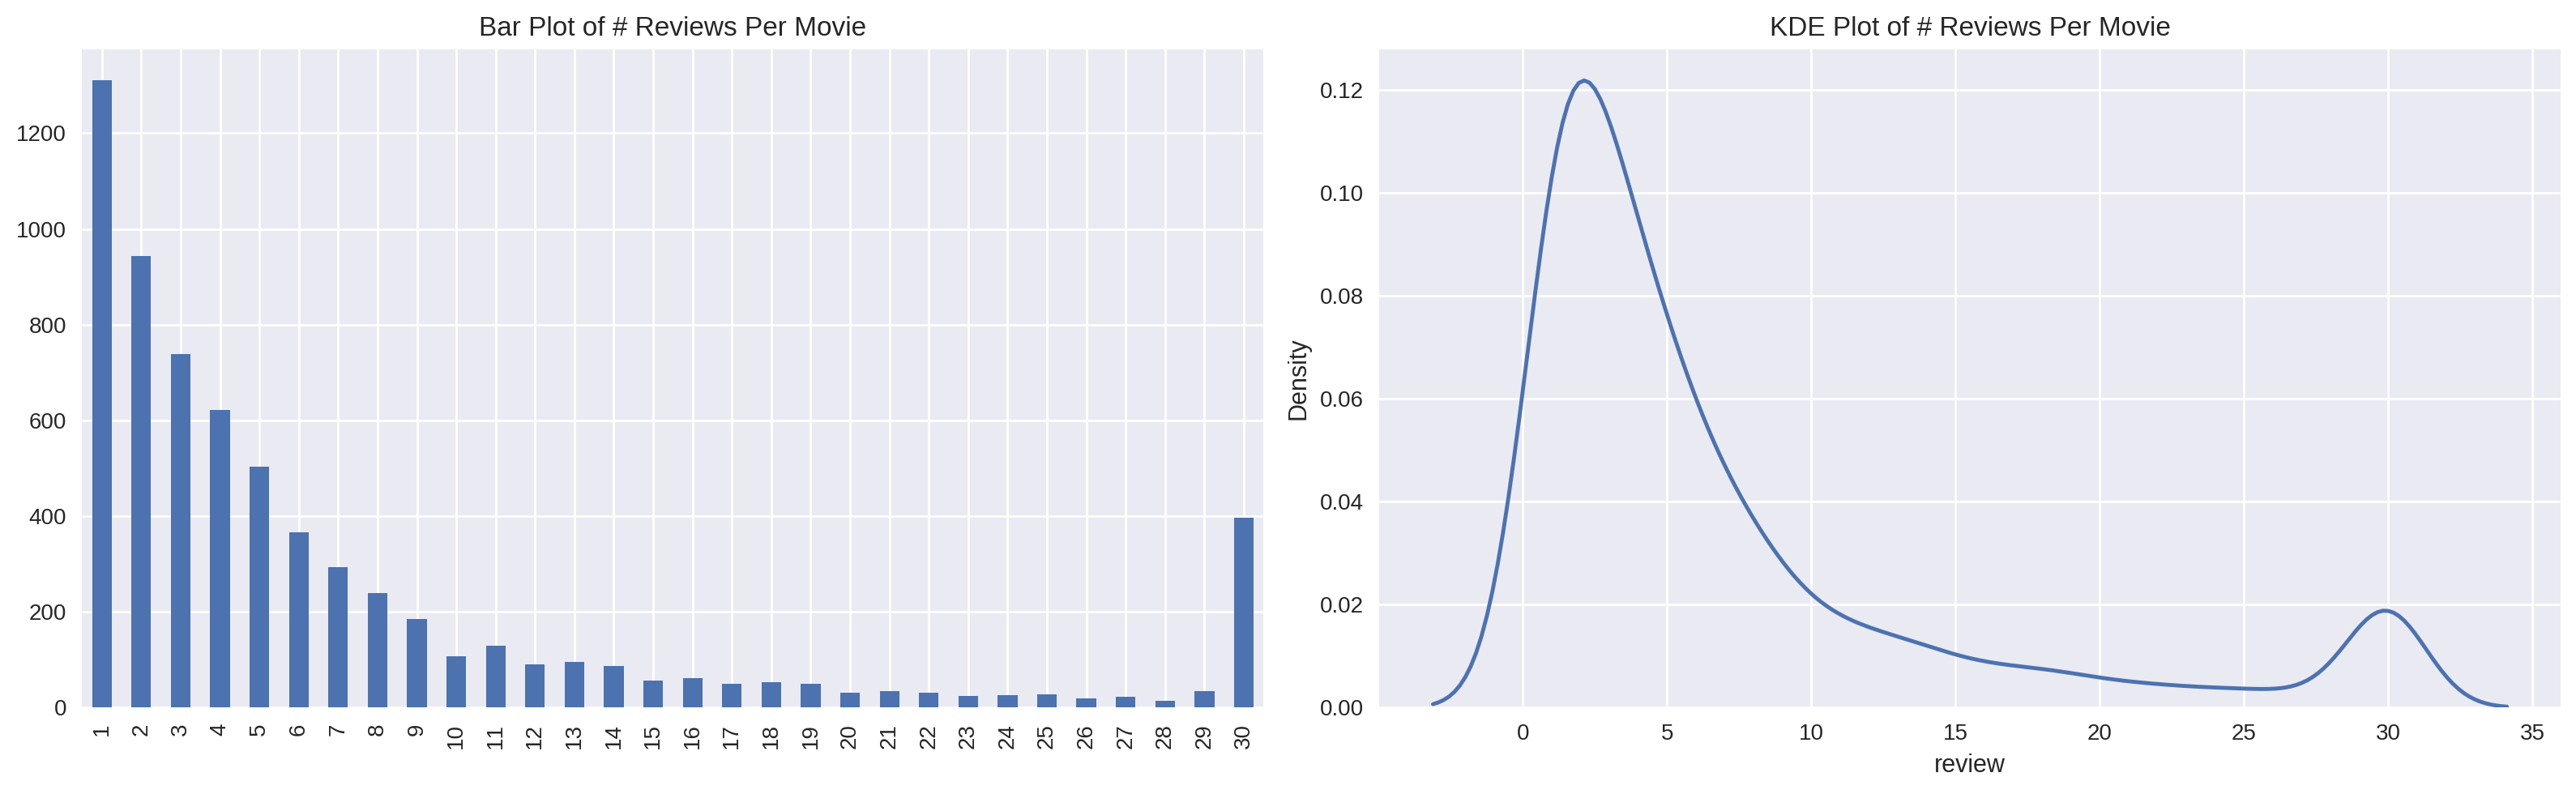

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of # Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of # Reviews Per Movie')

fig.tight_layout()

Another two subplots are visualized. The subplot on the left is a bar plot showing the distribution of the number of reviews per movie. The subplot on the right is a Kernel Density Estimation (KDE) plot, also representing the distribution of reviews per movie, but as a smooth probability density curve.

These subplots show that a majority of movies are likely to have no more than a few reviews, although these subplots alone do not help determine whether or not a positive or negative review is an influence on the amount of reviews a movie receives.

In [16]:
df_reviews['pos'].value_counts()

0    23680
1    23558
Name: pos, dtype: int64

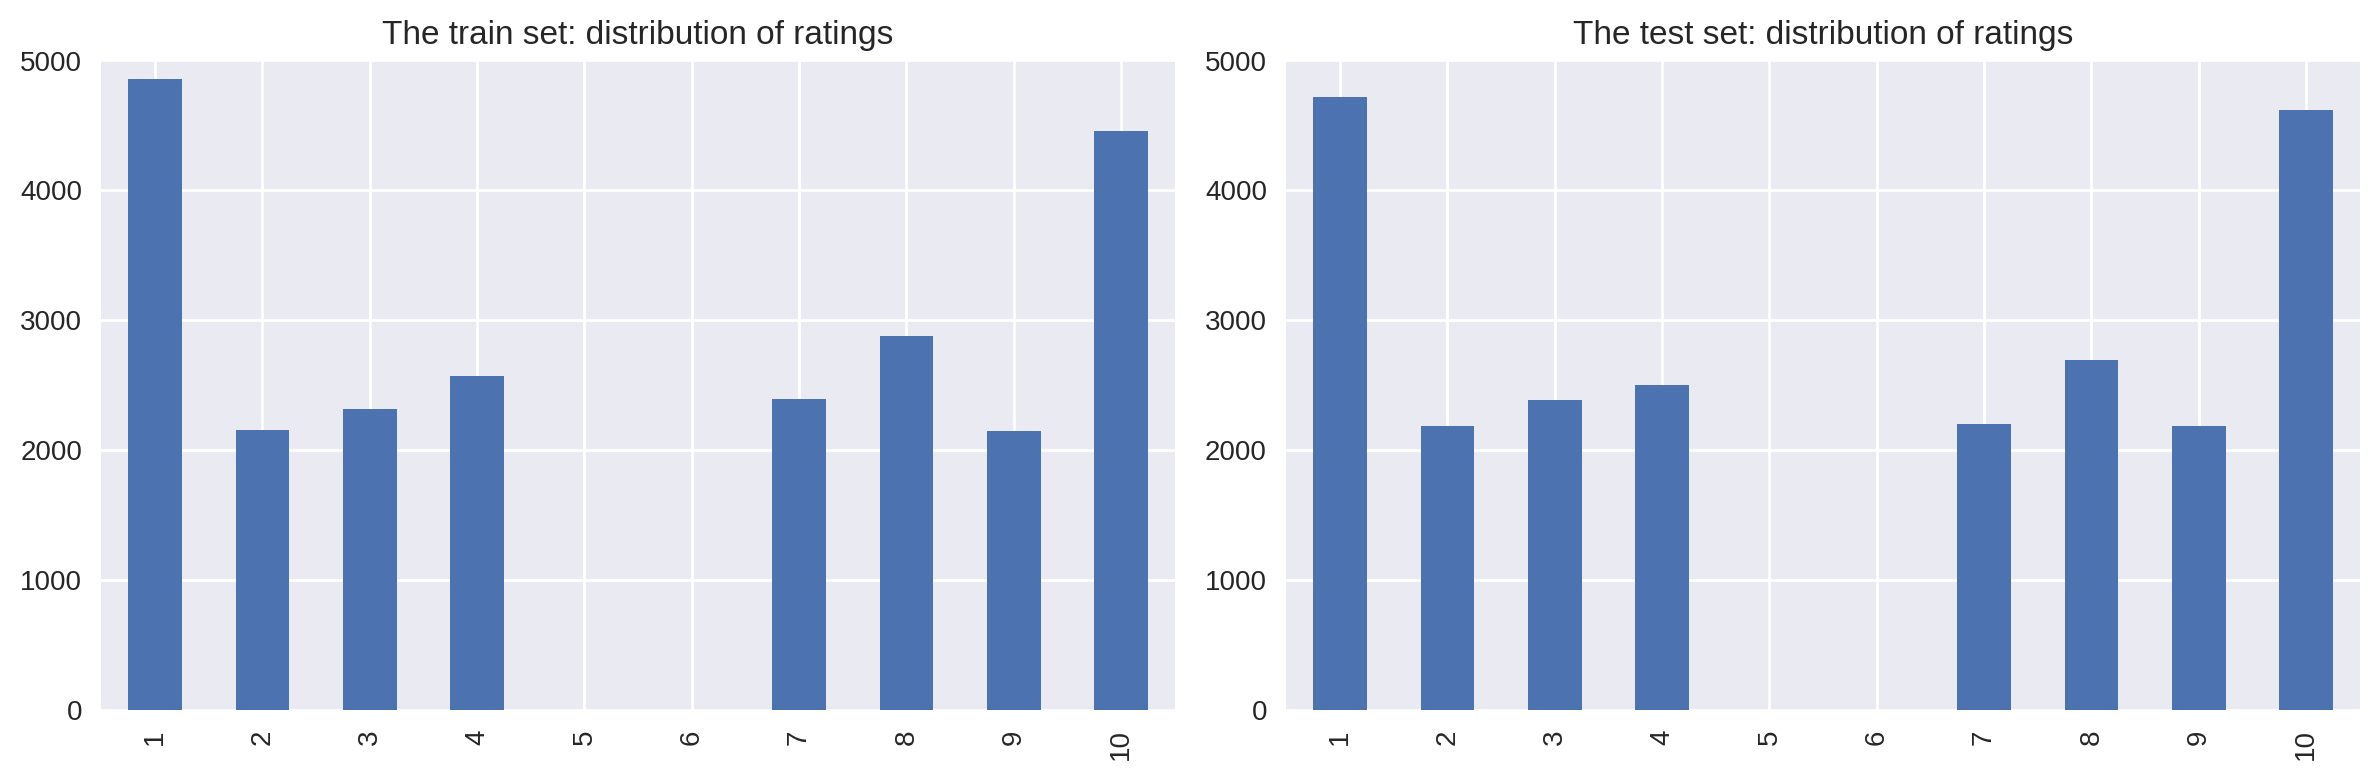

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Two bar plots are visualized to show the distribution of ratings in the training set and test set, respectively. This allows for a visual comparision of the distribution between the two datasets, which are almost identical.

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


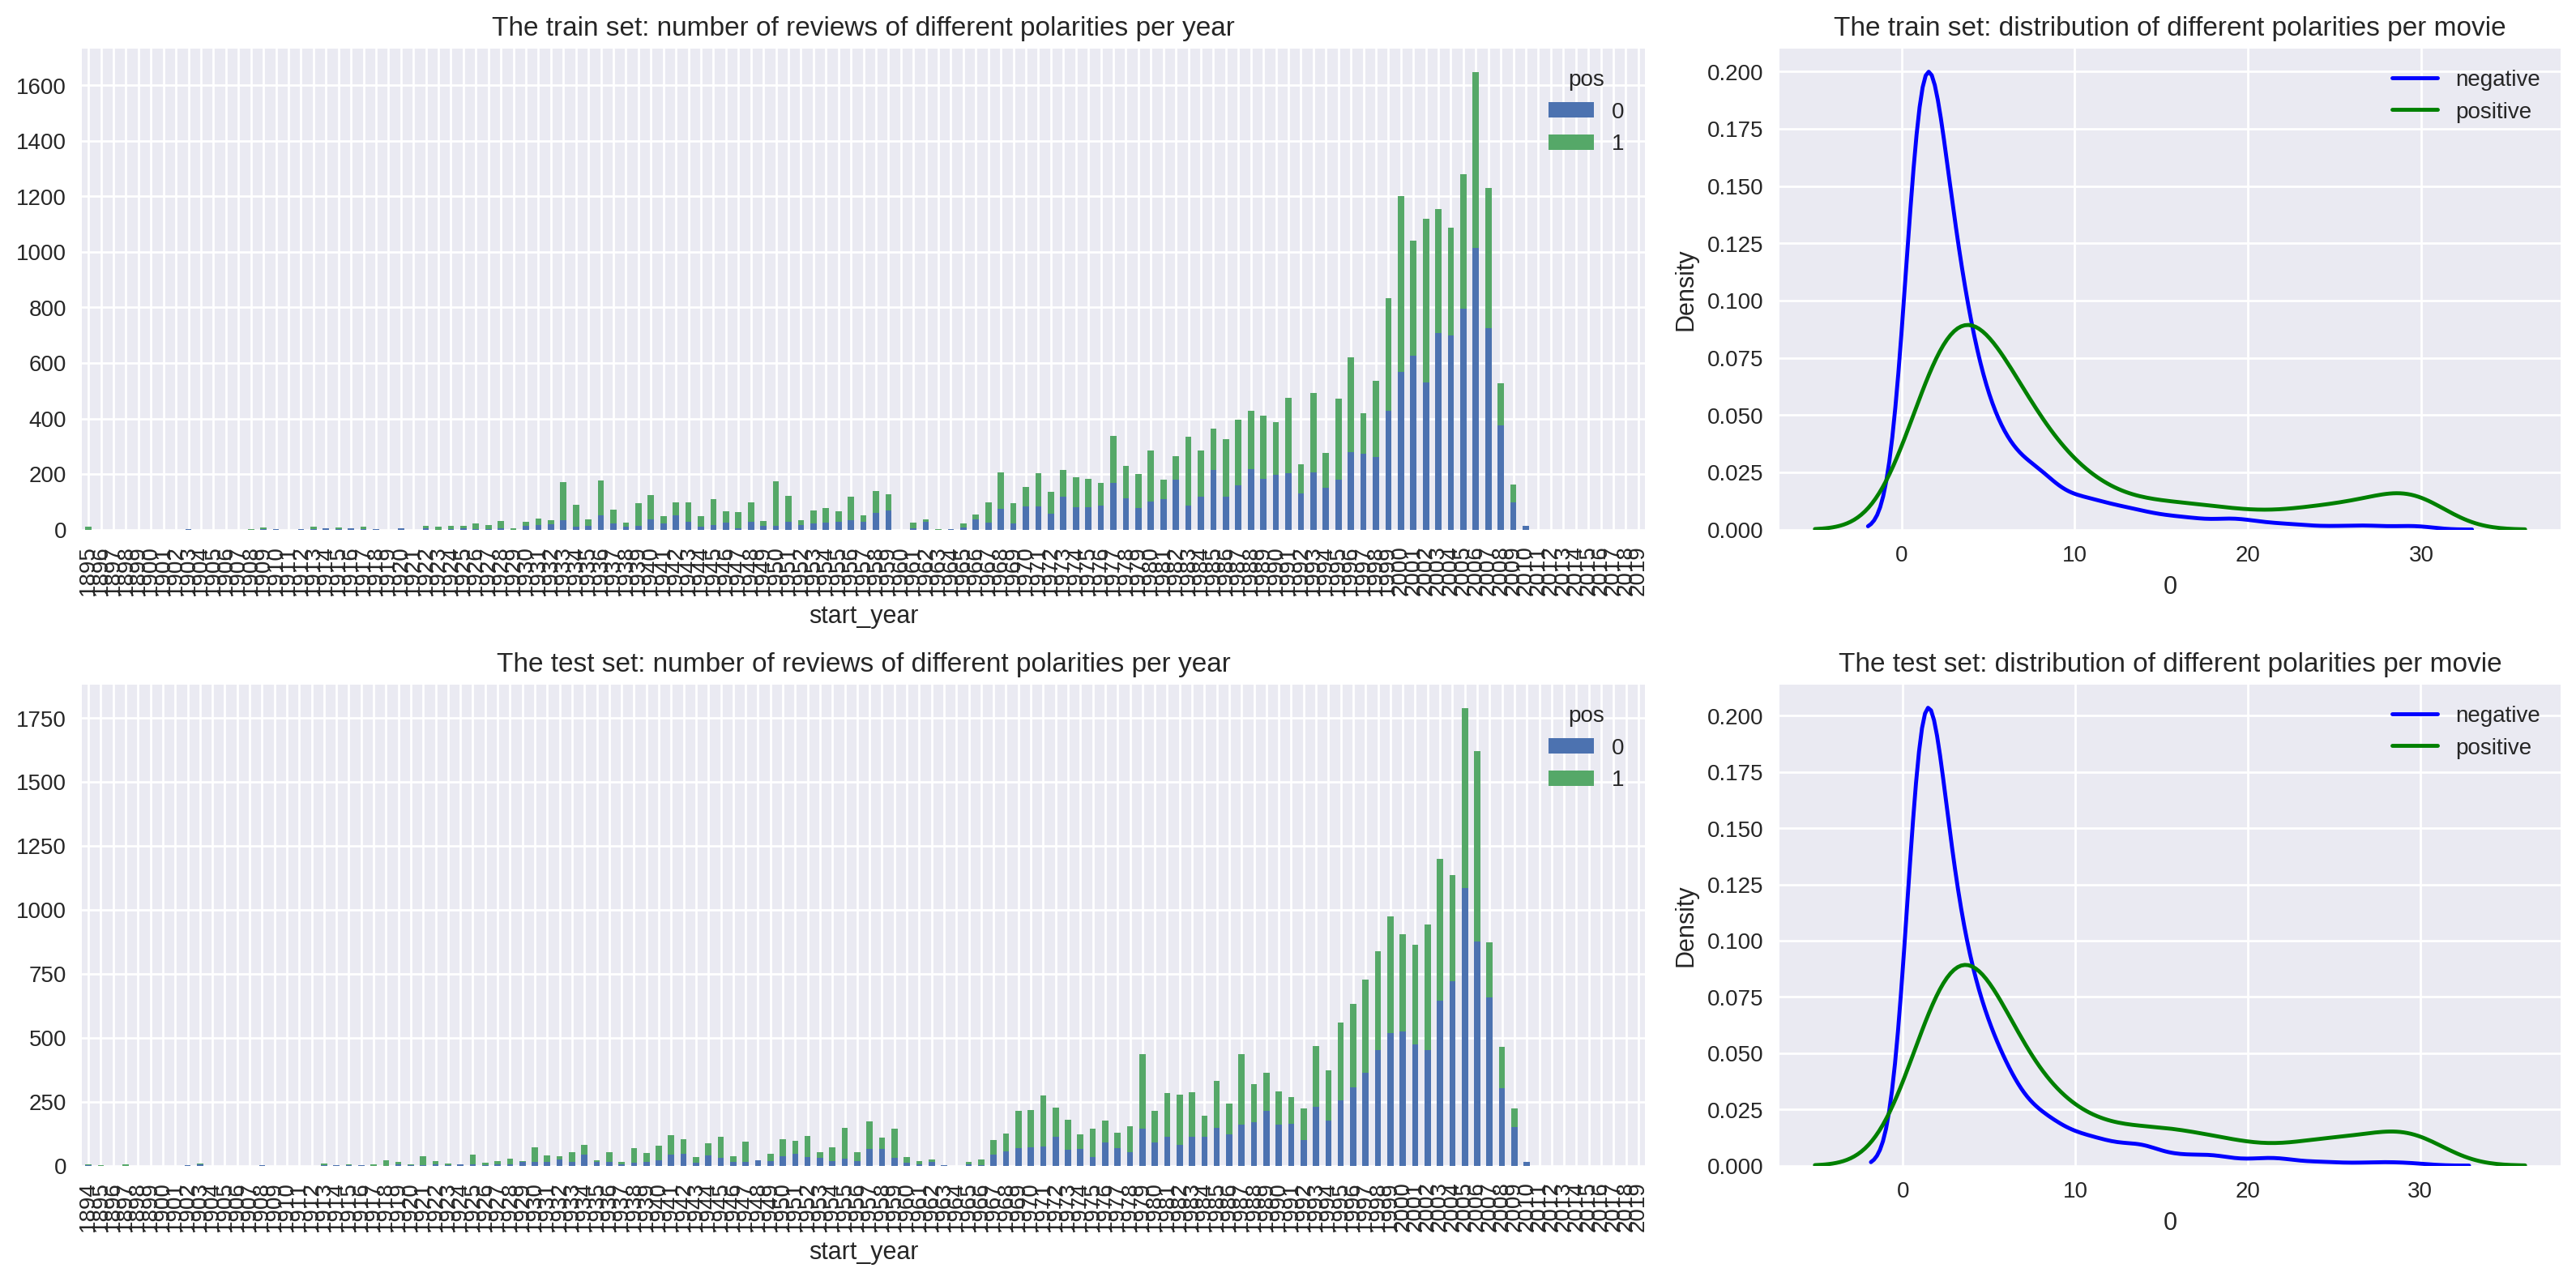

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

Distribution of positive and negative reviews over the years for two parts of the dataset.

The left column of plots visualize stacked bar charts showing the number of positive and negative reviews per year for the training set and test set, respectively. The right column of plots visualize KDE plots displaying the distribution of positive and negative reviews per movie for the training set and test set, respectively. Both distributions peak around 0-5 reviews per movie, with negative reviews having a higher, narrower peak.

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [19]:
def evaluate_model(model, features_train, target_train, features_test, target_test):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', features_train, target_train), ('test', features_test, target_test)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [20]:
def clear_text(text):
    text = text.lower()
    
    pattern = r'[^a-zA-Z\']'

    text = re.sub(pattern, ' ', text)

    text = ' '.join(text.split())
    
    return text

In [21]:
df_reviews['review_norm'] = df_reviews['review'].apply(clear_text)

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [22]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

features_train = df_reviews_train.drop('pos', axis=1)
features_test = df_reviews_test.drop('pos', axis=1)

target_train = df_reviews_train['pos']
target_test = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23757, 18)
(23481, 18)


## Working with models

### Model 0 - Constant

In [23]:
from sklearn.dummy import DummyClassifier

In [24]:
model_0 = DummyClassifier(strategy='uniform', random_state=12345)
model_0.fit(features_train, target_train)

DummyClassifier(random_state=12345, strategy='uniform')

          train  test
Accuracy    0.5   0.5
F1          0.5   0.5
APS         0.5   0.5
ROC AUC     0.5   0.5


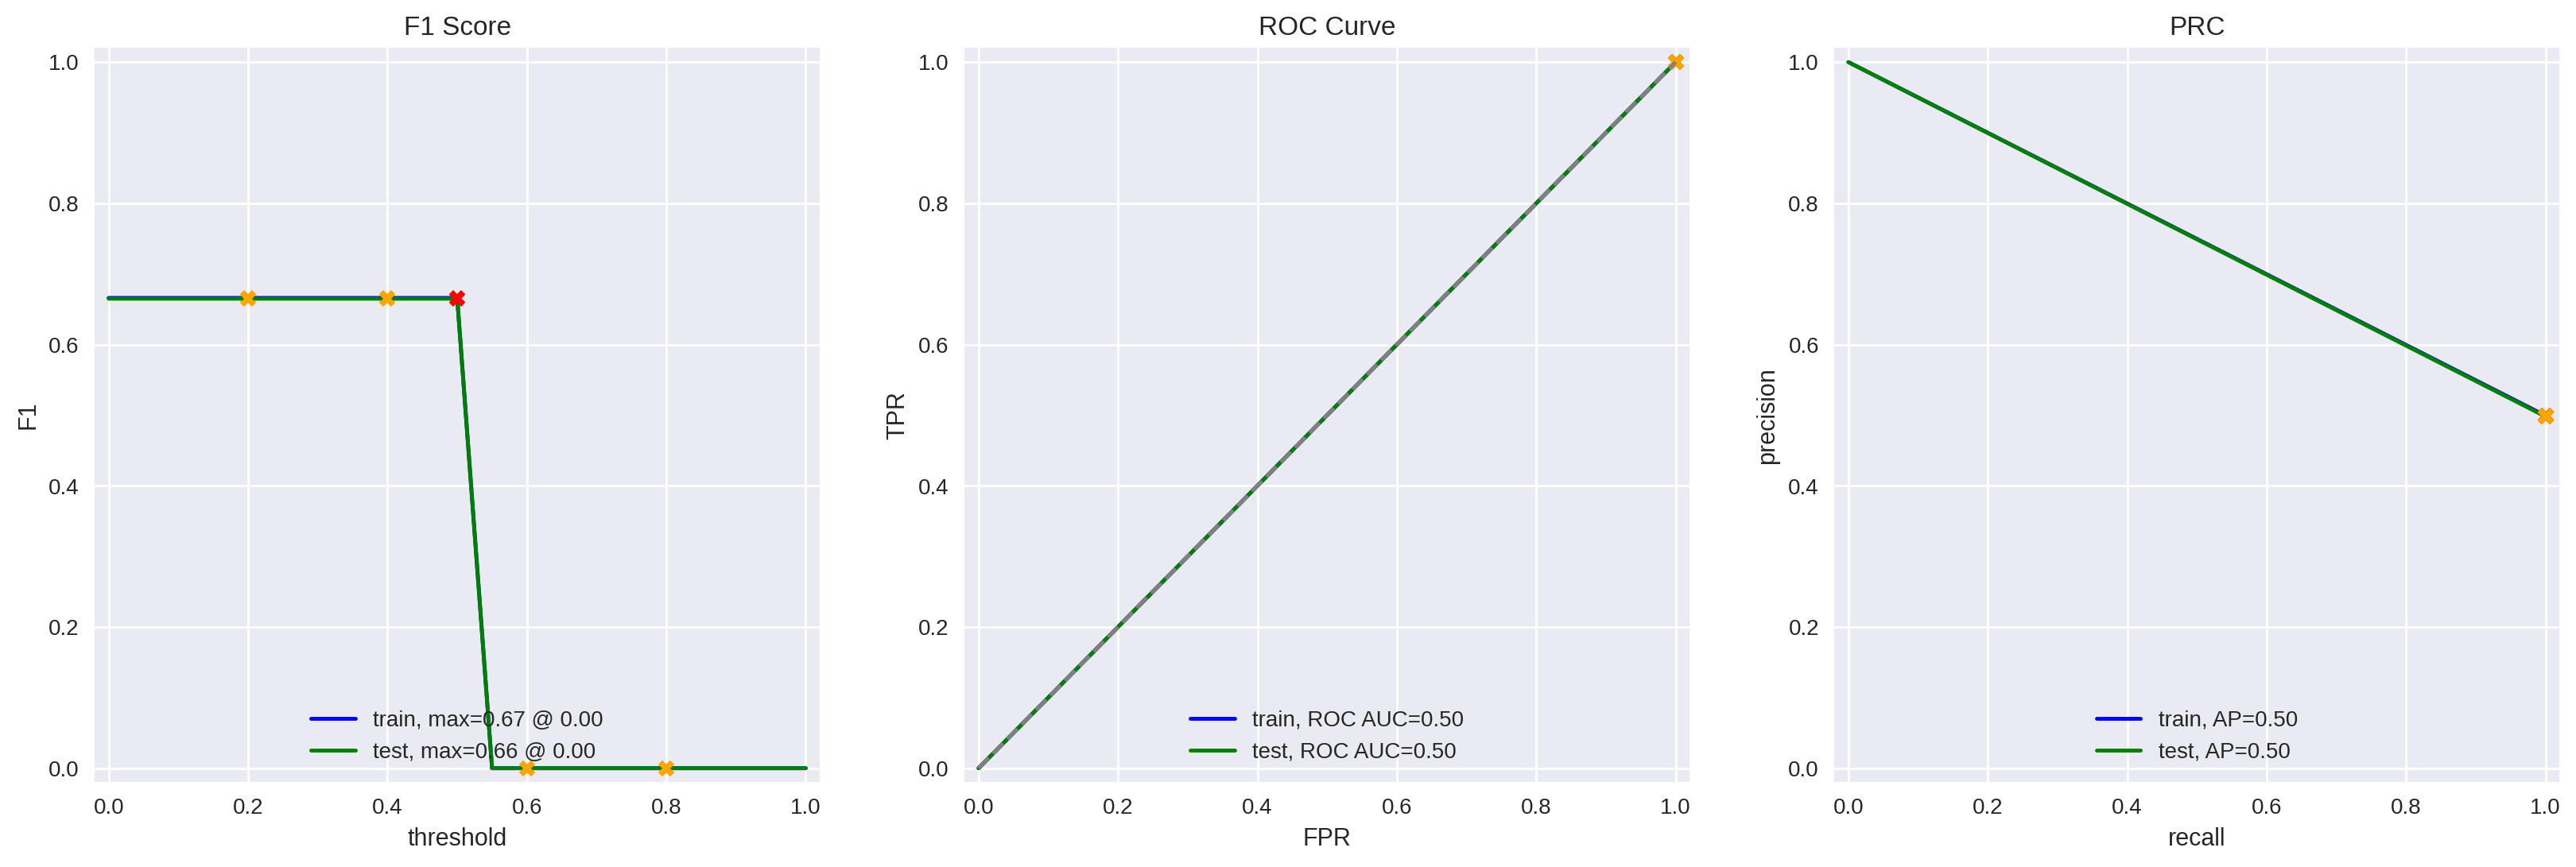

In [25]:
evaluate_model(model_0, features_train, target_train, features_test, target_test)

The baseline model is evaluated, showing no real meaningful scores as expected.

### Model 1 - NLTK, TF-IDF and LR

In [26]:
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [27]:
stop_words = stopwords.words('english')

In [28]:
# Text vectorization
lemmatizer = WordNetLemmatizer()

def text_preprocessing_1(text):
    tokens = word_tokenize(text.lower())

    lemmas = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(lemmas)

In [29]:
df_reviews_train['review_norm_1'] = df_reviews_train['review_norm'].apply(text_preprocessing_1)
df_reviews_test['review_norm_1'] = df_reviews_test['review_norm'].apply(text_preprocessing_1)

In [30]:
corpus_train_1 = df_reviews_train['review_norm_1']
corpus_test_1 = df_reviews_test['review_norm_1']

In [31]:
count_tf_idf_1 = TfidfVectorizer(stop_words=stop_words)
tf_idf_train_1 = count_tf_idf_1.fit_transform(corpus_train_1)
tf_idf_test_1 = count_tf_idf_1.transform(corpus_test_1)

In [32]:
features_train_1 = tf_idf_train_1
features_test_1 = tf_idf_test_1

print(features_train_1.shape)
print(features_test_1.shape)

(23757, 64297)
(23481, 64297)


In [33]:
model_1 = LogisticRegression(random_state=12345, solver='liblinear')
model_1.fit(features_train_1, target_train)

LogisticRegression(random_state=12345, solver='liblinear')

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


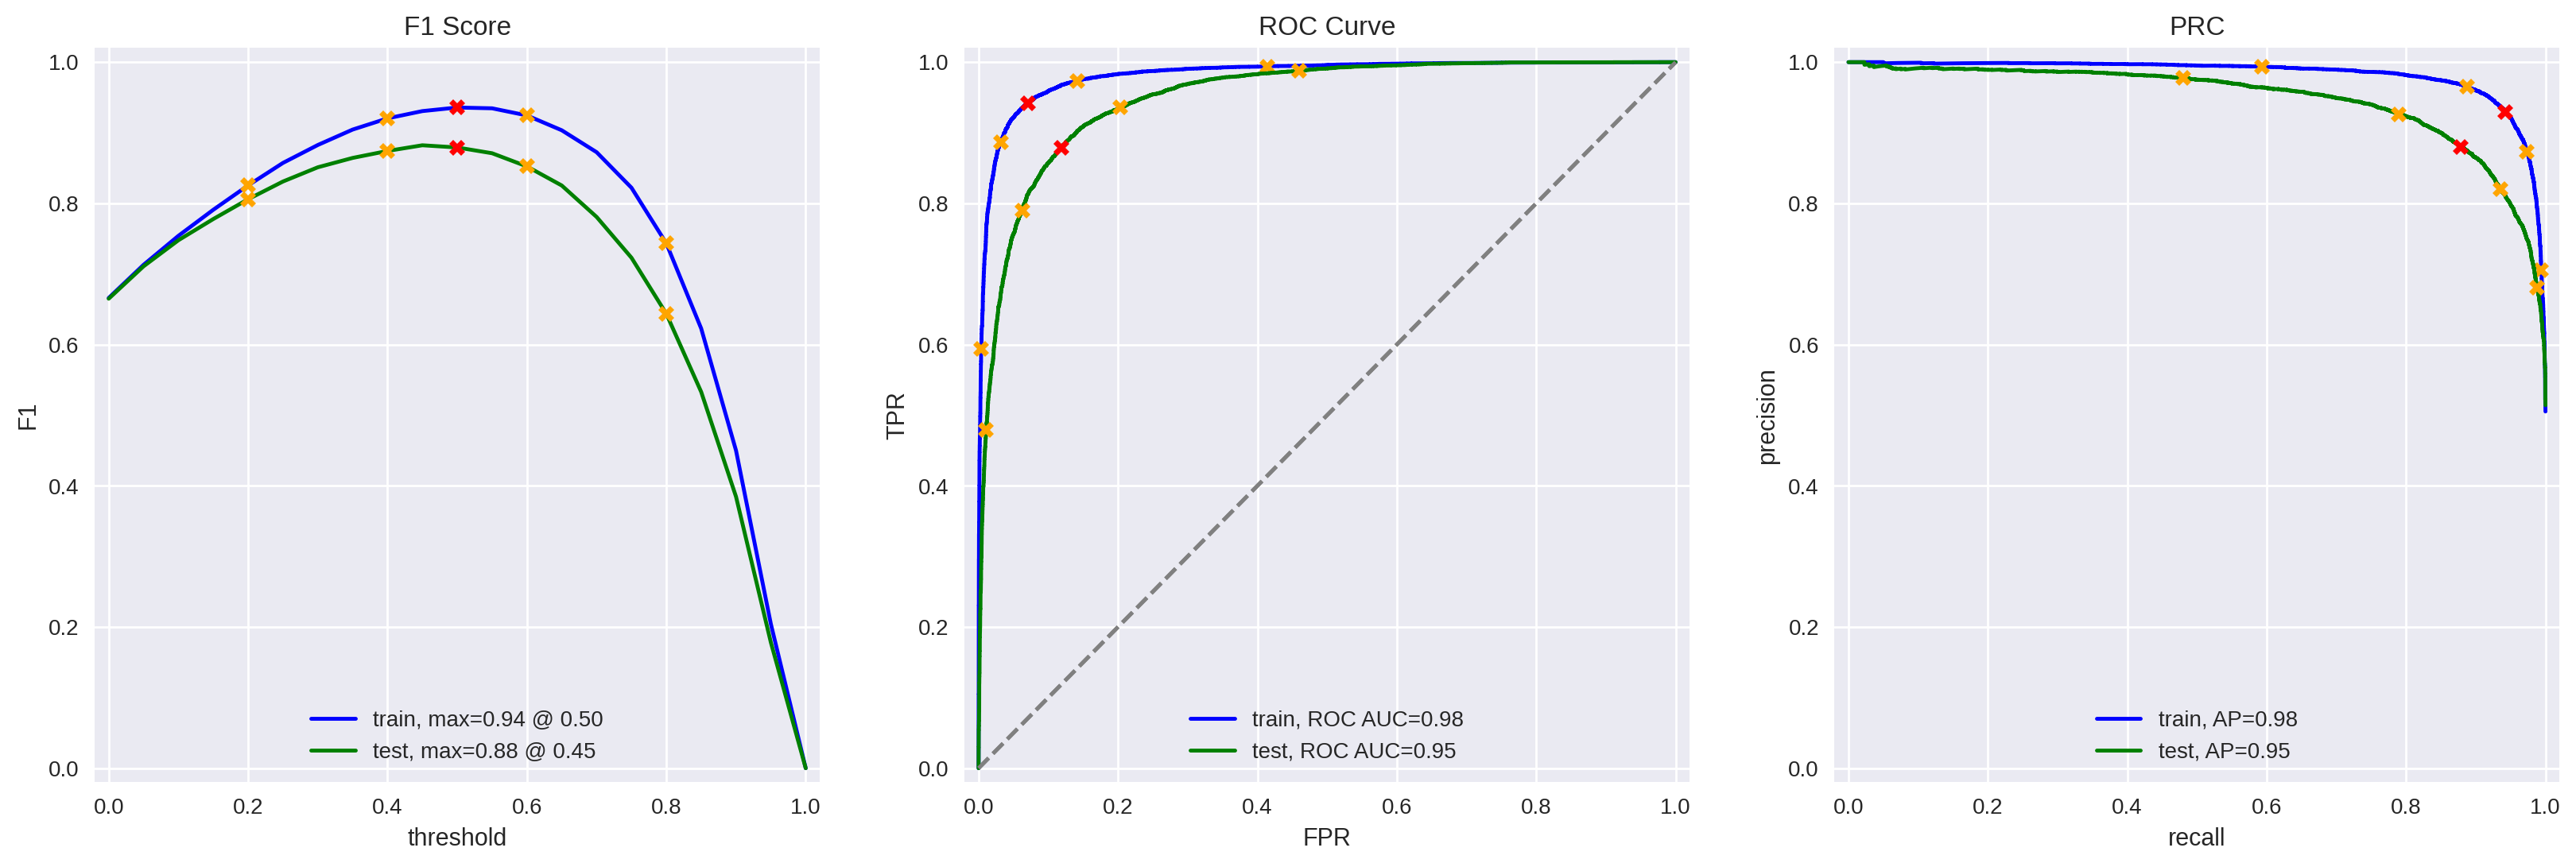

In [34]:
evaluate_model(model_1, features_train_1, target_train, features_test_1, target_test)

The first model (NLTK, TF-IDF, and Logistic Regression) is evaluated and looking promising. The F1 scores are as follows:

* 0.94 on the training set
* 0.88 on the test set

### Model 3 - spaCy, TF-IDF and LR

In [35]:
import spacy
# spacy.cli.download("en_core_web_sm")

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [36]:
def text_preprocessing_3(text):
    doc = nlp(text.lower())
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [37]:
df_reviews_train['review_norm_3'] = df_reviews_train['review_norm'].apply(text_preprocessing_3)
df_reviews_test['review_norm_3'] = df_reviews_test['review_norm'].apply(text_preprocessing_3)

KeyboardInterrupt: 

In [ ]:
corpus_train_3 = df_reviews_train['review_norm_3']
corpus_test_3 = df_reviews_test['review_norm_3']

In [ ]:
count_tf_idf_3 = TfidfVectorizer(stop_words=stop_words)
tf_idf_train_3 = count_tf_idf_3.fit_transform(corpus_train_3)
tf_idf_test_3 = count_tf_idf_3.transform(corpus_test_3)

In [ ]:
features_train_3 = tf_idf_train_3
features_test_3 = tf_idf_test_3

print(features_train_3.shape)
print(features_test_3.shape)

In [ ]:
model_3 = LogisticRegression(random_state=12345, solver='liblinear')
model_3.fit(features_train_3, target_train)

In [ ]:
evaluate_model(model_3, features_train_3, target_train, features_test_3, target_test)

The third model (spaCy, TF-IDF, and Logistic Regression) is evaluated and scoring almost as well as the first model (NLTK, TF-IDF, and Logistic Regression). The F1 scores are as follows:

* 0.93 on the training set
* 0.88 on the test set

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
# # Reuse features and target from the third model
# param_grid = {
#     'learning_rate': [0.05, 0.1, 0.2],
#     'n_estimators': [50, 100, 200],
#     'max_depth': [3, 5, 7]
# }

# model_4 = LGBMClassifier(random_state=12345)

# gs = GridSearchCV(model_4, param_grid=param_grid, scoring='f1', verbose=2) # NOTE: this takes about 6 min

# gs.fit(features_train_3, target_train)

# print(gs.best_score_)
# print(gs.best_params_)

In [ ]:
model_4 = LGBMClassifier(learning_rate=0.2, n_estimators=200, max_depth=5, random_state=12345)
model_4.fit(features_train_3, target_train)

<div class="alert alert-info">
<b>Comments:</b>

Hyperparameter tuning for this model was taking longer and longer so I'm just using preset params above and commenting out the grid search cell

In [ ]:
evaluate_model(model_4, features_train_3, target_train, features_test_3, target_test)

The fourth model (spaCy, TF-IDF, and Logistic Regression) is evaluated and also looking promising, with F1 scores almost matching the first model (NLTK, TF-IDF, and Logistic Regression)). The F1 scores are as follows:

* 0.94 on the training set
* 0.86 on the test set

###  Model 9 - BERT

In [ ]:
# import torch
# import transformers

# print(torch.cuda.is_available())

In [ ]:
# tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
# config = transformers.BertConfig.from_pretrained('bert-base-uncased')
# model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [ ]:
# def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
#     ids_list = []
#     attention_mask_list = []

#     # text to padded ids of tokens along with their attention masks
#     # create ids_list and attention_mask_list
#     for text in texts:
#         ids = tokenizer.encode(text, add_special_tokens=True, truncation=True, max_length=max_length)
#         padded = np.array(ids + [0] * (max_length - len(ids)))
#         attention_mask = np.where(padded != 0, 1, 0)
#         ids_list.append(padded)
#         attention_mask_list.append(attention_mask)
    
#     if force_device is not None:
#         device = torch.device(force_device)
#     else:
#         device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
#     model.to(device)
    
#     if not disable_progress_bar:
#         print(f'Using the {device} device.')

#     # added: improve performance of list to tensor conversion
#     ids_array = np.array(ids_list)
#     attention_mask_array = np.array(attention_mask_list)
    
#     # gettings embeddings in batches
#     embeddings = []

#     for i in tqdm(range(math.ceil(len(ids_array)/batch_size)), disable=disable_progress_bar):
#         start = batch_size * i
#         end = batch_size * (i + 1)
            
#         ids_batch = torch.LongTensor(ids_array[start:end]).to(device)
        
#         # create attention_mask_batch
#         attention_mask_batch = torch.LongTensor(attention_mask_array[start:end]).to(device)
            
#         with torch.no_grad():            
#             model.eval()
#             batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch) 
        
#         embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
#     return np.concatenate(embeddings)

In [ ]:
# sample_size=300

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# features_train_9 = BERT_text_to_embeddings(df_reviews_train.iloc[:sample_size]['review_norm'], batch_size=10, force_device=device)

In [ ]:
# features_test_9 = BERT_text_to_embeddings(df_reviews_test.iloc[:sample_size]['review_norm'], batch_size=10, force_device=device)

In [ ]:
# target_train_9 = df_reviews_train.iloc[:sample_size]['pos']
# target_test_9 = df_reviews_test.iloc[:sample_size]['pos']

In [ ]:
# print(df_reviews_train['review_norm'].shape)
# print(features_train_9.shape)
# print(target_train_9.shape)

In [ ]:
# model_9 = LogisticRegression(random_state=12345, solver='liblinear')
# model_9.fit(features_train_9, target_train_9)

In [ ]:
# evaluate_model(model_9, features_train_9, target_train_9, features_test_9, target_test_9)

In [ ]:
# The ninth model (BERT) is evaluated and the scores on the training set are all 1, which may or may not be accurate.

# Since running BERT for thousands of texts would've taken an especially long time (i.e. several hours), one modification was made to this model: the sample size was cut down to the first 300 rows.

# The F1 scores are as follows:

# * 1.0 on the training set
# * 0.79 on the test set

In [ ]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
# np.savez_compressed('features_9.npz', features_train_9=features_train_9, features_test_9=features_test_9)

# and load...
# with np.load('features_9.npz') as data:
#     features_train_9 = data['features_train_9']
#     features_test_9 = data['features_test_9']

<div class="alert alert-info">
<b>Comments:</b>

I'm ultimately excluding the ninth model (BERT) since the kernel kept crashing for me, despite the effort to cut down on the sample size used

## My Reviews

In [ ]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(clear_text)
my_reviews['review_norm_1'] = my_reviews['review'].apply(text_preprocessing_1) # reuse function from model 1 training
my_reviews['review_norm_3'] = my_reviews['review'].apply(text_preprocessing_3) # reuse function from model 3 training

display(my_reviews)

corpus = my_reviews['review_norm']

### Model 2

In [ ]:
corpus_2 = my_reviews['review_norm_1']

model_2 = model_1

my_reviews_pred_prob = model_2.predict_proba(count_tf_idf_1.transform(corpus_2))[:, 1]

for i, review in enumerate(corpus_2.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

Class probabilities are computed in a second model (in actuality, this repurposes the first model of the main task using NLTK, TF-IDF, and Logistic Regression) on the `my_reviews` dataset. The model comes close to correctly evaluating positive vs. negative reviews.

### Model 3

In [ ]:
my_reviews_pred_prob = model_3.predict_proba(count_tf_idf_3.transform(corpus.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(corpus.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

Next, class probabilities are computed in a third model (repurposing the third model of the main task using spaCy, TF-IDF, and Logistic Regression) on the `my_reviews` dataset. This model evaluates a few reviews as negative when they should be classified as positive.

### Model 4

In [ ]:
my_reviews_pred_prob = model_4.predict_proba(count_tf_idf_3.transform(corpus.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(corpus.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

Finally, class probabilities are computed in a fourth model (repurposing the fourth model of the main task that uses spaCy, TF-IDF and LGBMClassifier) on the `my_reviews` dataset. The model also fares poorly like the previous model (spaCy, TF-IDF, and Logistic Regression), this time its evaluation making inaccurate classifications: negative as positive, and vice versa.

### Model 9

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# my_reviews_features_9 = BERT_text_to_embeddings(corpus, force_device=device, disable_progress_bar=True)

# my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

# for i, review in enumerate(corpus.str.slice(0, 100)):
#     print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

<div class="alert alert-info">
<b>Comments:</b>

Reiterating that I'm excluding the ninth model (BERT) here

## Conclusions

Using the provided dataset of movie reviews to classify positive vs. negative reviews, several models were trained and tested.

Of all of the models evaluated, the first model (NLTK, TF-IDF, and Logistic Regression) produced the best results with the following F1 scores:

* 0.94 on the training set
* 0.88 on the test set

In a follow-up, the same model also did well classifying reviews on a smaller dataset (`my_reviews`) as compared to the other models trained.

The F1 metric's threshold of scoring of being at least 0.85 has been met by the first model (NLTK, TF-IDF, and Logistic Regression).